# Tutorial for binary classification using _ImaGene_

This is a short tutorial to learn the basic usage of _ImaGene_ which contains a series of objects in _python_ to interact with _keras_.

In this example our aim is to predict whether a given locus is under natural selection from population genomic data.
Therefore, we will use _ImaGene_ to perform a binary classification and we will use the classic example of positive selection for lactase persistence in human populations.

The C/T(-13910) variant, or rs4988235, is located on chromosome 2 in the _MCM6_ gene but influences the lactase _LCT_ gene. This SNP is associated with the primary haplotype associated with lactose intolerance in European populations.
In these populations, the common T allele is associated with lactase persistence. Individuals who are homozygous for C allele are likely to be lactose intolerant.
We extracted SNP information from a region of 80k base pairs around the target variant rs4988235 from the 1000 Genomes Project data for all unrelated individuals of CEU population (of European descent).
The data is in the form of a VCF file.

In this tutorial, you will learn how to:
1. read data from VCF file and store it into _ImaGene_ objects,
2. run and process simulations to be used for training,
3. implement, train and evaluate the neural network,
4. deploy the trained network on your genomic data of interest.

In [1]:
# Cloning the repository from GitHub into the Colab environment
!git clone https://github.com/Djinho/Project_CNN.git
# Changing directory to 'BinaryClassification' within the cloned repo
%cd Project_CNN/BinaryClassification
# Printing the current working directory
!pwd


Cloning into 'Project_CNN'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 57 (delta 24), reused 3 (delta 1), pack-reused 0
Receiving objects: 100% (57/57), 1.95 MiB | 6.93 MiB/s, done.
Resolving deltas: 100% (24/24), done.
/content/Project_CNN/BinaryClassification
/content/Project_CNN/BinaryClassification


Before starting, we need to load the necessary modules in _python_ ...

In [2]:
import os
import gzip
import _pickle as pickle

import numpy as np
import scipy.stats
import arviz

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, activations, optimizers, regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

import itertools
import matplotlib.pyplot as plt
import skimage.transform
from sklearn.metrics import confusion_matrix
import pydot # optional, but required by keras to plot the model


... and _ImaGene_.

In [3]:
%run -i ../ImaGene.py

This tutorial has been tested with:
* python 3.9.7
* numpy 1.19.5
* scipy 1.7.1
* keras 2.6.0
* tensorflow 2.6.0
* scikit-image 0.18.3
* scikit-learn 1.0
* matplotlib 3.4.3
* pydot 1.4.2
* pymc3 3.11.4
* ipython 7.28.0
* jupyterlab 3.1.14

### 1. Read data from VCF file and store it into _ImaGene_ objects



In [5]:
file_LCT = ImaFile(nr_samples=198, VCF_file_name='../LCT.CEU.vcf')

In [6]:
gene_LCT = file_LCT.read_VCF()

In [7]:
gene_LCT.summary();

An object of 1 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 2200, max 2200, mean 2200.000000, std 0.000000


As expected, we have one image with 198 rows (equivalent to the number of sampled chromosomal copies) and 2200 columns representing all genomic positions reported.
It is likely that not all of these positions will be polymorphic in the CEU sample as the VCF file reports variats across all analysed populations.

Similarly, we may want to discard rare variants as they may be more associated to errors or be less informative of the scenario we want to predict.
Assume that we want to ignore monomorphic sites and singletons for the derived allele.
We can accomplish this with the following command.

In [12]:
gene_LCT.filter_freq(0.01);

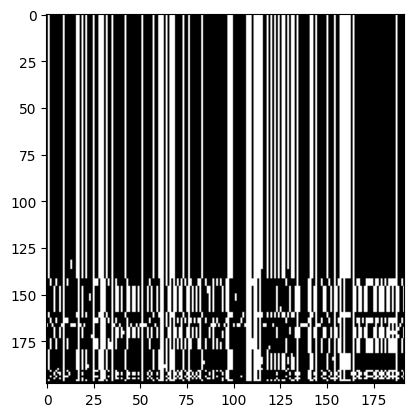

In [13]:
gene_LCT.plot();

Assume that we wish to sort only rows by their frequency (with the most frequent haplotypes on the top).
This can be done with the following command (which will also visualise the resulting image).

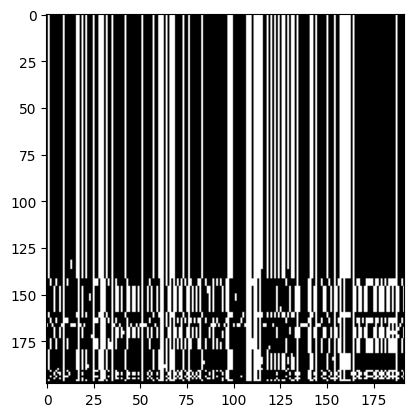

In [14]:
gene_LCT.sort('rows_freq');
gene_LCT.plot();

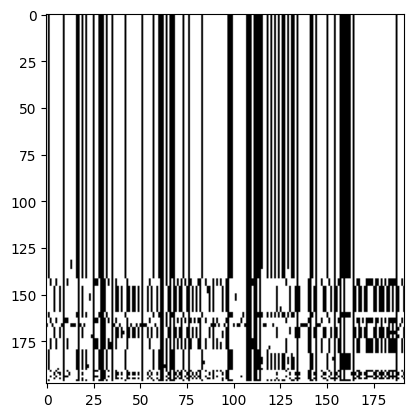

An object of 1 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 192, max 192, mean 192.000000, std 0.000000


In [15]:
gene_LCT.convert(flip=True);
gene_LCT.plot();
gene_LCT.summary();

We finally note that our image has 192 columns now, representing the number of retained SNPs.

We can save our _ImaGene_ object in the working `path` directory.

In [16]:
path = './'

In [17]:
gene_LCT.save(file=path + 'gene_LCT');

In [18]:
gene_LCT = load_imagene(file=path + 'gene_LCT');

### 2. Run and process simulations to be used for training the neural network


ImaGene facilitates simulation execution through msms for network training. The script ../generate_dataset.sh employs ../params.txt to configure simulations, with an example file params_binary provided. This example simulates 200,000 loci of 80kbp under neutral evolution or positive selection (allelic selection coefficient: $1.5$%) starting 20kya, with a mutation rate of $1.5e-8$ and recombination rate of $1e-8$. Population simulation follows a 3-epoch model by Marth et al. (2004) for European populations, sampling 198 chromosomal copies. Specify msms directories and simulation storage folder, then execute simulations for training.

In [19]:
# if you wish to generate new training data, do not run otherwise
import subprocess
subprocess.call("bash ../generate_dataset.sh params_binary.txt".split());

In [20]:
#variable to store path
path_sim = './'

In [21]:
#store simulations into a imafile object
file_sim = ImaFile(simulations_folder=path_sim + 'Binary/Simulations1', nr_samples=198, model_name='Marth-3epoch-CEU');

In [22]:
#populate the imagene object specifying the variable we want to estimate/predict
gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=2000);

In [ ]:
#Look at the data stored in this object
gene_sim.summary();

An object of 2000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 133, max 491, mean 292.001000, std 65.080903


We have 4000 images in this object. Recall that with the first line we simulated 2 classes and retained 2000 data points for each class. All images have 198 rows as expected, as this represents the number of simulated haplotypes. However, images have different number of columns, ranging from $\approx 130$ to $\approx 450$ with an average value of $\approx 295$. The number of columns represents the number of polymorphic sites and fixed derived alleles in a _msms_ file. This number may vary from simulated gene to another.
Our observed data for LCT has 192 columns.

As mentioned before, _ImaGene_ provides functionalities to manipulate our data. Specifically we can do the following:
* convert ancestral/derived to major/minor allele polarisation
* filter out columns based on a minimum allele frequency (e.g. 0.01)
* sorting rows and columns by frequency (or genetic distance from the most frequent entry)

We need to follow the same data processing as the one employed for the real data.

In [ ]:
gene_sim.filter_freq(0.01);
gene_sim.sort('rows_freq');
gene_sim.summary();

An object of 2000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 76, max 369, mean 216.447000, std 53.794648


All images must have the same dimensions. You can explore all different options for resizing.

In [24]:
?gene_sim.resize

One possibility would be to resize them to match the dimensions of the real data.
In this case it means resize all images to have shape (198, 192) which can be achieved with the following command.

In [25]:
gene_sim.resize((198, 192));
gene_sim.summary();

An object of 2000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 192, max 192, mean 192.000000, std 0.000000


After the data manipulation is done, we need to convert images to proper _numpy_ float matrices,as previously discussed. The following line will do the job (including flipping black/white pixels).
Note that the `.convert` method allows you to normalise the data too.

In [26]:
gene_sim.convert(flip=True);
gene_sim.summary();

An object of 2000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 192, max 192, mean 192.000000, std 0.000000


Note that in addition to the genomic data, an _ImaGene_ object contains information on the corresponding targets (in this case the selection coefficient, either 0 or 300 in $2N_e$ units with $N_e = 10000$).
As an illustration, let's plot one random image per class.

0


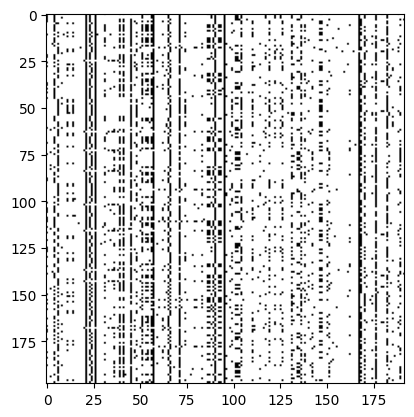

300


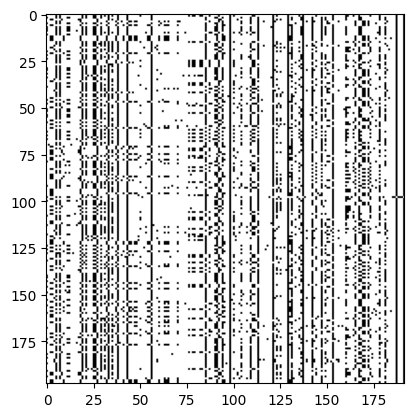

In [27]:
for sel in gene_sim.classes:
    print(sel)
    gene_sim.plot(np.where(gene_sim.targets == sel)[0][0])

In [31]:
#Randomly shuffle the images to use them in the network
gene_sim.subset(get_index_random(gene_sim));

In [32]:
#vectorise the images as requried by keras
gene_sim.targets = to_binary(gene_sim.targets);

In [33]:
#Save the object it now ready for classification
gene_sim.save(file=path + 'gene_sim.binary')

0

In [34]:
#load imagene object using the function
gene_sim = load_imagene(file=path + 'gene_sim.binary')

### 3. Implement, train and evaluate the neural network

Now that our data is ready, we can build our network.
Specifically, we can build a model in _keras_ with convolutional, pooling and dense layers.
In this example we have 3 layers of 2D convolutions and pooling followed by a fully-connected layer.
We just need to specify the dimensions of the data in the first layer, and this is specified by the option `input_shape=gene_sim.data.shape[1:]`.

In [35]:
model = models.Sequential([
                    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid', input_shape=gene_sim.data.shape[1:]),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Flatten(),
                    layers.Dense(units=128, activation='relu'),
                    layers.Dense(units=1, activation='sigmoid')])

Then, let's compile our _keras_ model.

In [36]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Let's look at a summary of the model and plot it.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 196, 190, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 98, 95, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 93, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 46, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 44, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 23, 22, 64)        0

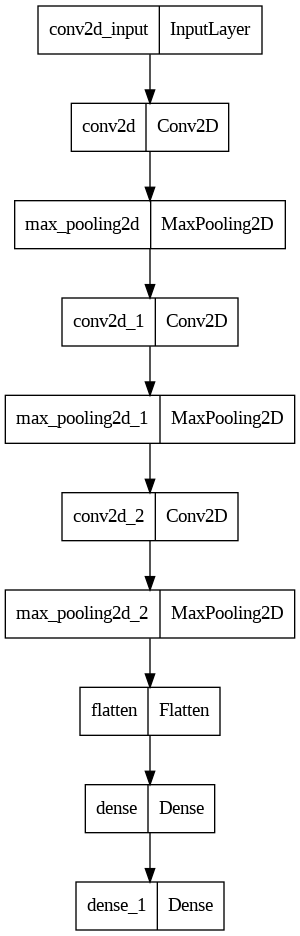

In [37]:
model.summary()
plot_model(model, path + 'net.binary.png')

Now we are ready for doing the training on this first batch of data.

In [38]:
score = model.fit(gene_sim.data, gene_sim.targets, batch_size=64, epochs=1, verbose=1, validation_split=0.10)

29/29 [==============================] - 87s 3s/step - loss: 5.4605 - accuracy: 0.4939 - val_loss: 3.8708 - val_accuracy: 0.5150


In [39]:
#intialise the network using ImaNet
net_LCT = ImaNet(name='[C32+P]x2+[C64+P]+D128')

In [40]:
#Keep track of scores e.g loss and accuracy
net_LCT.update_scores(score);

Now we need to repeat the whole procedure described above using all remaning batches of data, leaving the last one for testing.

In [41]:
i = 2
while i < 10:

    print(i)

    file_sim = ImaFile(simulations_folder=path_sim + 'Binary/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')
    gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=2000)

    gene_sim.filter_freq(0.01)
    gene_sim.sort('rows_freq')
    gene_sim.resize((198, 192))
    gene_sim.convert(flip=True)

    gene_sim.subset(get_index_random(gene_sim))
    gene_sim.targets = to_binary(gene_sim.targets)

    score = model.fit(gene_sim.data, gene_sim.targets, batch_size=64, epochs=1, verbose=1, validation_split=0.10)
    net_LCT.update_scores(score)

    i += 1

2
29/29 [==============================] - 78s 3s/step - loss: 2.9458 - accuracy: 0.5617 - val_loss: 2.1054 - val_accuracy: 0.4600
3
29/29 [==============================] - 77s 3s/step - loss: 1.6201 - accuracy: 0.5428 - val_loss: 1.2333 - val_accuracy: 0.5400
4
29/29 [==============================] - 78s 3s/step - loss: 1.0624 - accuracy: 0.5422 - val_loss: 0.9242 - val_accuracy: 0.5850
5
29/29 [==============================] - 77s 3s/step - loss: 0.8877 - accuracy: 0.5722 - val_loss: 0.8449 - val_accuracy: 0.5050
6
29/29 [==============================] - 89s 3s/step - loss: 0.8252 - accuracy: 0.6128 - val_loss: 0.8988 - val_accuracy: 0.4750
7
29/29 [==============================] - 78s 3s/step - loss: 0.7846 - accuracy: 0.6800 - val_loss: 0.8242 - val_accuracy: 0.5600
8
29/29 [==============================] - 77s 3s/step - loss: 0.7169 - accuracy: 0.7256 - val_loss: 0.7261 - val_accuracy: 0.6350
9
29/29 [==============================] - 78s 3s/step - loss: 0.6206 - accuracy: 0

We can plot loss and validation accuracy during the training to check, for instance, for overfitting.

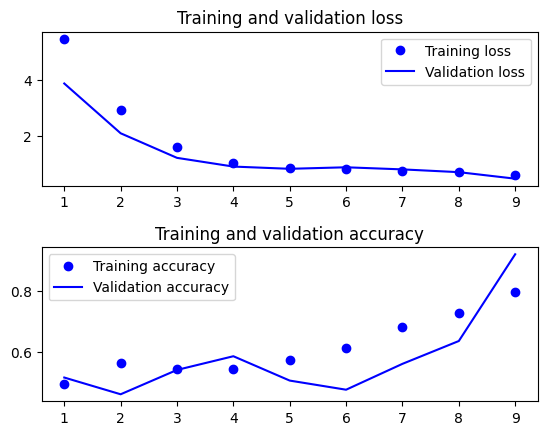

0

In [42]:
net_LCT.plot_train()

We save (and/or load) the final trained model.

In [43]:
model.save(path + 'model.binary.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [44]:
model = load_model(path + 'model.binary.h5')

You can also save the network itself (and load it).

In [45]:
net_LCT.save(path + 'net_LCT.binary');

In [46]:
net_LCT = load_imanet(path + 'net_LCT.binary')

Finally, we evaluate the training on the testing dataset, i.e. the last batch of simulated data.

In [47]:
i = 10
file_sim = ImaFile(simulations_folder=path_sim + 'Binary/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')
gene_sim_test = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=2000)

gene_sim_test.filter_freq(0.01)
gene_sim_test.sort('rows_freq')
gene_sim_test.resize((198, 192))
gene_sim_test.convert(flip=True)

rnd_idx = get_index_random(gene_sim_test) # no need to create this extra variable
gene_sim_test.subset(rnd_idx)

gene_sim_test.targets = to_binary(gene_sim_test.targets);

Let's report loss and accuracy on the testing set.

In [48]:
net_LCT.test = model.evaluate(gene_sim_test.data, gene_sim_test.targets, batch_size=None, verbose=0)
print(net_LCT.test) # it will report [loss, accuracy]

[0.5088427662849426, 0.9229999780654907]


For a binary (or multiclass) classification, it is convenient to plot the confusion matrix after predicting the responses from the testing data.

63/63 [==============================] - 24s 382ms/step


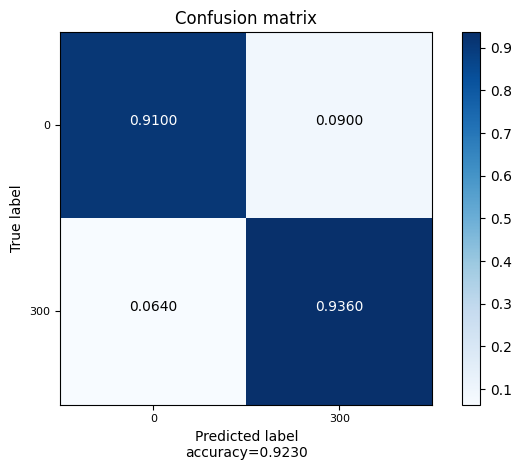

0

In [49]:
net_LCT.predict(gene_sim_test, model)
net_LCT.plot_cm(gene_sim_test.classes, text=True)

### 4. Deploy the trained network on your genomic data of interest

Finally we can use the trained network to predict natural selection on our locus of interest.
The output of this command will give us the class score (e.g. this can be interpreted as a posterior probability with uniform prior) of said locus under positive selection under the conditions we simulated.

In [50]:
print(model.predict(gene_LCT.data, batch_size=None)[0][0])

1/1 [==============================] - 0s 34ms/step
0.93250686
